<a href="https://colab.research.google.com/github/KCL-Machine-Learning/dqn_atari/blob/main/Playing_Atari_Games_with_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to install tools that help run open ai gym
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assau

# Playing Atrai games with Neural Network

### Papers: 
- [Playing Atari with Deep Reinforcment Learning](https://arxiv.org/pdf/1312.5602.pdf)
- [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236.pdf)

In [ ]:
# Mount google drive for you to save files in your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Before running this create a folder named DQN to save files inside there
%cd /content/drive/My\ Drive/DQN 

/content/drive/My Drive/DQN


In [ ]:
import gym
import numpy as np
import tensorflow as tf
import random
import time
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display
from collections import deque, namedtuple

In [ ]:
# Helper function to display each state as gym's render itself doesn't work on colab
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

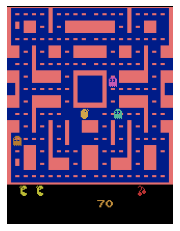

0.0 False {'ale.lives': 3}


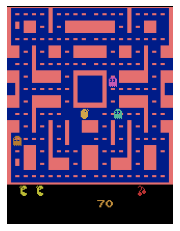

In [ ]:
# Random play
env = gym.make('MsPacman-ram-v0')
for i_episode in range(1):
    observation = env.reset()
    for t in range(200):
        show_state(env)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print(reward, done, info)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

In [ ]:
observation, observation.max()

(array([  0,  50,  33,  34,  82,  35,  18, 117, 110,  66,  80,   0, 127,
         98,  71,  88,  98,   0,   1,   3,   0,   0,   0,   0,   0,   1,
         10,   8, 133,   7, 156,   0,  45,   2,   0, 208,  57, 232, 232,
        255,   0,   0,  17,  37,  36, 120,   0,  53,  82, 109, 121, 134,
          3, 222,   0,   1,   3,   0,   8,  80, 255, 255,   0, 255, 255,
         80, 255, 255,  80, 255, 255,  80, 255, 255,  80, 191, 191,  80,
        191, 191,  80, 191, 191,  80, 191, 171,  80, 255, 239,  80, 255,
        175,  80, 255, 255,   0, 255, 255,  80, 255, 255,  20, 223,  43,
        217,  99, 217, 123, 217, 123, 217, 123, 217, 123, 217, 221,   0,
         63,   1,   7, 112,   0,   0,   2,  98, 250, 146, 215], dtype=uint8),
 255)

In [ ]:
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [29]:
ENV_NAME = "MsPacman-ram-v0"            # Environment name
env = gym.make(ENV_NAME)
ACTION_SIZE = env.action_space.n        # number of possible actions
INPUT_DIM = env.observation_space.shape # input dimension for the network
BUFFER_SIZE = int(1e6)                  # replay buffer size
BATCH_SIZE = 32                         # minibatch size
GAMMA = 0.99                            # discount factor
PARAM_UPDATE_EVERY = 10                 # how often to update the parameters
TARGET_UPDATE_EVERY = 10000             # how often to update the target network
START_LEARNING = 1000                   # start learning after how many steps

env.close()

In [35]:
class ReplayBuffer:
    def __init__(self, size=BUFFER_SIZE, input_shape=INPUT_DIM):
        """
        Arguments:
            size: Integer, Number of stored transitions
            input_shape: Shape of the preprocessed frame
        """
        self.size = size
        self.input_shape = input_shape
        self.count = 0    # total index of memory written to, always less than self.size
        self.current = 0  # index to write to

        # Pre-allocate memory
        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.states = np.empty((self.size, *self.input_shape), dtype=np.float32)
        self.next_states = np.empty((self.size, *self.input_shape), dtype=np.float32)
        self.dones = np.empty(self.size, dtype=np.bool)


    def add(self, state, action, reward, next_state, done):
        """Saves a transition to the replay buffer
        Arguments:
            action: An integer between 0 and env.action_space.n - 1 
                determining the action the agent perfomed
            state: Current state information of the game. For the current env, it is a (128,) array consisting of the information in the RAM
            next_state: Next state resulted by the action taken
            reward: A float determining the reward the agend received for performing an action
            done: A bool stating whether the episode terminated
        """

        self.actions[self.current] = action
        self.states[self.current, ...] = state
        self.next_states[self.current, ...] = next_state
        self.rewards[self.current] = reward
        self.dones[self.current] = done
        self.count = max(self.count, self.current+1)
        self.current = (self.current + 1) % self.size

    def sample(self, batch_size=BATCH_SIZE):
        """Returns a minibatch of self.batch_size = 32 transitions
        Arguments:
            batch_size: How many samples to return
        Returns:
            A tuple of states, actions, rewards, new_states, and dones
        """

        # Get a list of valid indices randomly
        indices = random.sample(range(0, self.count), batch_size)
       
        states = tf.convert_to_tensor(self.states[indices], dtype=tf.float32)
        actions = tf.convert_to_tensor(self.actions[indices], dtype=tf.int32)
        rewards = tf.convert_to_tensor(self.rewards[indices], dtype=tf.float32)
        next_states = tf.convert_to_tensor(self.next_states[indices], dtype=tf.float32)
        dones = tf.convert_to_tensor(self.dones[indices], dtype=tf.float32)
        return states,  actions, rewards, next_states, dones

    def save(self):
        """Save the replay buffer to a folder"""
        np.save('actions.npy', self.actions)
        np.save('states.npy', self.sates)
        np.save('next_states.npy', self.next_states)
        np.save('rewards.npy', self.rewards)
        np.save('dones.npy', self.dones)

    def load(self):
        """Loads the replay buffer from a folder"""
        self.actions = np.load('actions.npy')
        self.states = np.load('states.npy')
        self.next_states = np.load('next_states.npy')
        self.rewards = np.load('rewards.npy')
        self.dones = np.load('dones.npy')
    
    def __len__(self):
        return self.count

In [36]:
class Agent():

    def __init__(self, input_dim, action_size=9, seed=123):

        # Iniitialize the models, ensure target has same weights as local
        tf.random.set_seed(seed)
        self.local_model = self.__build_model__(input_dim, action_size)
        self.local_model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001))
        self.target_model = self.__build_model__(input_dim, action_size)
        self.target_model.set_weights(self.local_model.get_weights())

        self.action_size = action_size
        self.input_dim = input_dim
        self.start_learning = False

        # Empty memory buffer
        self.memory = ReplayBuffer()
        
        # To count number of steps agent has played
        self.t_step = 0

    def __build_model__(self, input_dim, action_size):
        # Simple one layer model created here
        input_layer = tf.keras.layers.Input(shape=input_dim)
        x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(input_layer)
        output = tf.keras.layers.Dense(action_size, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)

        """
        # If you would want to do image output you can replace abouve bit with these 
        # this architecture was suggested by the paper as well


        input_layer = tf.keras.layers.Input(shape=input_dim)
        x = tf.keras.layers.Conv2D(32, (3,3), strides=4, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(input_layer)
        x = tf.keras.layers.Conv2D(64, (3,3), strides=2, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)
        x = tf.keras.layers.Conv2D(64, (3,3), strides=1, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)
        output = tf.keras.layers.Dense(action_size, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)

        """
    
        return tf.keras.Model(inputs=input_layer, outputs=output)
    
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = self.t_step + 1 
        
        # Only after START_LEARNING step the model starts learning and updating the local model. Does to accumulate transitions in the memory buffer
        if not self.start_learning and self.t_step % START_LEARNING == 0:
            self.start_learning = True
            
        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > BATCH_SIZE and self.start_learning and self.t_step % PARAM_UPDATE_EVERY == 0:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        # Every TARGEt_UPDATE_EVERY step update target network to be same as local network        
        if self.start_learning and self.t_step % TARGET_UPDATE_EVERY == 0:
            self.update_target_network()
            self.t_step = 0

    def act(self, state, eps=0.):
        # Epsilon greedy policy
        # Lower the epsilon, more likely agent takes action determined by the model instead of random action.
        action_values = self.local_model.predict(state)
        if random.random() > eps:
            action = np.argmax(action_values)
        else:
            action = random.choice(np.arange(self.action_size))
        
        return action
    
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        target_q_next = tf.reduce_max(self.target_model.predict(next_states), axis=1)
        target_q = rewards + (gamma * target_q_next * (1-dones))

        # Block here determiens Q value for current state using local model. Only collects the Q value for action taken and determiens Huber loss between local model's Q
        # vs target model's Q value. 
        with tf.GradientTape() as tape:
            q_values = self.local_model(states, training=True)
            one_hot_actions = tf.keras.utils.to_categorical(actions, self.action_size, dtype=np.float32)
            predicted_q = tf.reduce_sum(tf.multiply(q_values, one_hot_actions), axis=1)
            loss = tf.keras.losses.Huber()(target_q, predicted_q)
        
        # Uses the loss to determien gradients and apply the changes to local model's weights
        model_gradients = tape.gradient(loss, self.local_model.trainable_weights)
        self.local_model.optimizer.apply_gradients(zip(model_gradients, self.local_model.trainable_weights))

    def update_target_network(self):
        self.target_model.set_weights(self.local_model.get_weights())


In [37]:
def evaluate(agent, render=False):
    env = gym.make(ENV_NAME)
    state = env.reset()
    state = tf.cast(state, tf.float32)
    state /= 255
    state = tf.expand_dims(state, axis=0)
    score = 0
    lives = 3
    for t in range(400):
        if render:
            show_state(env)
        action = int(agent.act(state, 0.))
        state, reward, done, info = env.step(action)
        if info['ale.lives'] < lives:
            reward = -1.0
            lives = info['ale.lives']
            life_lost = True
        elif reward > 0:
            reward = 1
        state = tf.cast(state, tf.float32)
        state /= 255
        state = tf.expand_dims(state, axis=0)
        score += reward
        if done and lives == 0:
            break
    env.close()
    return score

In [38]:
def dqn(agent, n_episodes=2000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.9969, train=True, window_size=50):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): to update agent or not
    """
    max_score = -100
    scores = []                                # list containing scores from each episode
    scores_window = deque(maxlen=window_size)  # last window_size scores
    eps = eps_start                            # initialize epsilon
    print("Starting training")
    
    env = gym.make(ENV_NAME)
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = tf.cast(state, tf.float32)
        state /= 255
        score = 0
        lives = 3
        for t in range(max_t):
            action = int(agent.act(tf.expand_dims(state, axis=0), eps))
            next_state, reward, done, info = env.step(action) 

            # modifying rewards to make agent aware doing nothing or losing life is bad
            # and clipping any positive score to 1, as it helps stable learning.
            if info['ale.lives'] < lives:
                reward = -1.0
                done = True
                lives = info['ale.lives']
            elif reward > 0:
                reward = 1
            else:
                reward = -0.5

            next_state = tf.cast(next_state, tf.float32)
            next_state /= 255.0
            
            if train:
                agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward
            if done and lives == 0:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tT_Step: {},Average Score: {:.2f},Max score: {:.2f},Min score: {:.2f},eps: {:.2f}'.format(i_episode, agent.t_step, np.mean(scores_window), np.max(scores_window), np.min(scores_window), eps), end="")
        if train:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            if i_episode % window_size == 0:
                # agent.memory.save() # Commnted out this as it takes up a lot of space 
                agent.local_model.save_weights('pacman_local_model_checkpoint_v2')
                agent.target_model.save_weights('pacman_target_model_checkpoint_v2')
                print('\rEpisode {}\tAverage Score: {:.2f},Max score: {:.2f},Min score: {:.2f},eps: {:.3f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), np.min(scores_window), eps))
    env.close()
    return scores

In [ ]:
agent = Agent(INPUT_DIM, ACTION_SIZE)
# agent.local_model.load_weights('pacman_local_model_checkpoint')
# agent.update_target_network()

In [ ]:
scores = dqn(agent, n_episodes=1000, max_t=400, eps_start=1.0, eps_decay=0.995)

Starting training
Episode 2	T_Step: 800,Average Score: -176.50,Max score: -175.00,Min score: -178.00,eps: 0.99Starting learning from 1000
Episode 50	Average Score: -174.91,Max score: -152.00,Min score: -184.50,eps: 0.778
Episode 100	Average Score: -170.16,Max score: -149.00,Min score: -187.50,eps: 0.606
Episode 150	Average Score: -166.80,Max score: -141.50,Min score: -182.50,eps: 0.471
Episode 200	Average Score: -162.11,Max score: -140.00,Min score: -178.00,eps: 0.367
Episode 250	Average Score: -157.48,Max score: -128.00,Min score: -181.50,eps: 0.286
Episode 295	T_Step: 8000,Average Score: -156.23,Max score: -125.00,Min score: -181.00,eps: 0.23

In [ ]:
evaluate(agent, True)

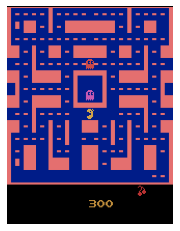

27.0

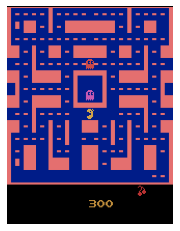

In [27]:
agent = Agent(INPUT_DIM, ACTION_SIZE)
agent.local_model.load_weights('pacman_local_model_checkpoint')
agent.update_target_network()
evaluate(agent, True)